In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pydicom

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#jpeg path
#/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_8909618.jpg
#/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_7385112.jpg
#/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_2639174.jpg

#dicom path
#/kaggle/input/siim-isic-melanoma-classification/train/ISIC_5251830.dcm
#/kaggle/input/siim-isic-melanoma-classification/train/ISIC_8712312.dcm
#/kaggle/input/siim-isic-melanoma-classification/train/ISIC_6053196.dcm



# Perform basic EDA to build better model

In [4]:
train_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv")
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
#Let's see random rows
train_df.sample(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
28532,ISIC_8633889,IP_1730314,male,35.0,upper extremity,unknown,benign,0
16895,ISIC_5166798,IP_9927968,male,25.0,torso,melanoma,malignant,1
6293,ISIC_1977122,IP_8356528,female,40.0,lower extremity,nevus,benign,0
759,ISIC_0333102,IP_3854976,female,45.0,head/neck,unknown,benign,0
19247,ISIC_5843515,IP_8673016,female,55.0,head/neck,unknown,benign,0


In [6]:
import pandas_profiling

In [7]:
#train_df.profile_report()

Takeaways from the report: 
1. No missing target rows
2. All image names are unique
3. A few missing gender and age entries. These can be dropped from the training set. 

In [8]:
test_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv")
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [9]:
test_df['image_name'].tail(6)

10976    ISIC_9992226
10977    ISIC_9992485
10978    ISIC_9996992
10979    ISIC_9997917
10980    ISIC_9998234
10981    ISIC_9999302
Name: image_name, dtype: object

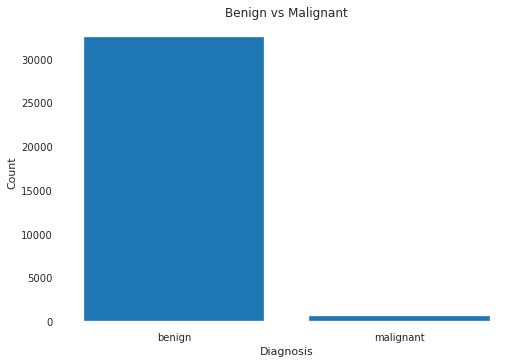

In [10]:
#Let's see distribution of benign vs non
diagnosis=train_df['benign_malignant'].value_counts()
plt.bar(diagnosis.index, diagnosis);
plt.title('Benign vs Malignant')
plt.xlabel('Diagnosis')
plt.ylabel('Count');

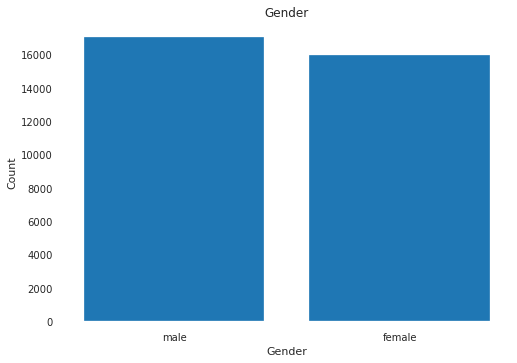

In [11]:
Gender=train_df['sex'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

In [12]:
#Gender vs. target
z=train_df.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Blues')  

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


In [13]:
#Total number of images (combined)
print("Total images in Train set: ",train_df['image_name'].count())
print("Total images in Test set: ",test_df['image_name'].count())

Total images in Train set:  33126
Total images in Test set:  10982


In [14]:
#Inpect what is needed in sample submission
submission_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
submission_df.sample(3)

,image_name,target
6171,ISIC_5634577,0
4442,ISIC_4097756,0
9508,ISIC_8662209,0


In [15]:
#submission_df['target']=

In [16]:
import matplotlib.pyplot as plt
import pydicom

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [18]:
train_df.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


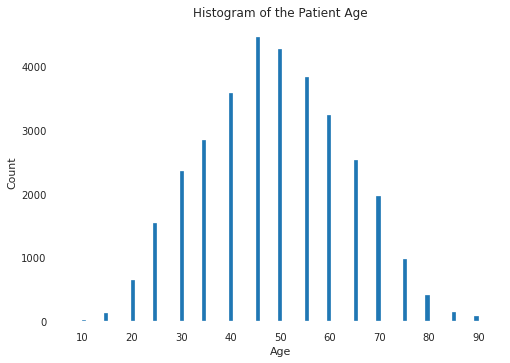

In [19]:
plt.hist(train_df['age_approx'],bins=100);
plt.xlim(5,95);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

In [20]:
#Find various diagnosis
train_df.diagnosis.to_list()
train_df.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

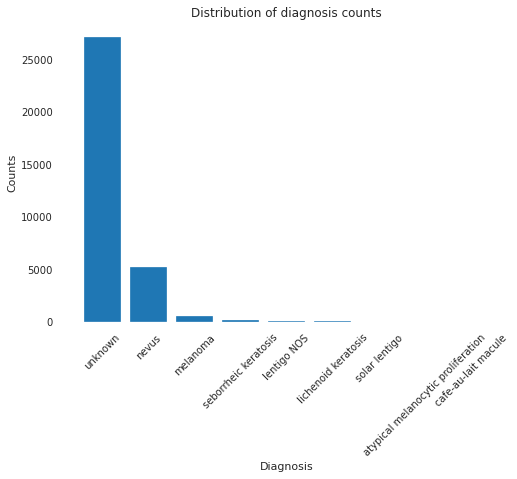

In [21]:
#Let's plot distribution on the diagnosis
diag = train_df['diagnosis'].value_counts()
plt.bar(diag.index, diag);
plt.title('Distribution of diagnosis counts')
plt.xlabel('Diagnosis')
plt.ylabel('Counts');
plt.xticks(rotation=45);

In [22]:
#See if there are any duplicate patient IDs
#train_df.set_index('patient_id', inplace=True)
#train_df.sample(2)
train_df[train_df.duplicated()]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target


In [23]:
#See if there are any nulls or missing values
#train_df.isnull()
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB
None


In [24]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB
None


In [25]:
#read one DCM file for metadata
dcm = pydicom.dcmread("/kaggle/input/siim-isic-melanoma-classification/train/ISIC_6692344.dcm")
dcm

(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.5962.99.1.7697.1569.1589907705295.1.1.0.0.0
(0008, 0020) Study Date                          DA: '20200519'
(0008, 0023) Content Date                        DA: '20200519'
(0008, 0030) Study Time                          TM: '170144'
(0008, 0033) Content Time                        TM: '170144'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: '"XC"'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0080) Institution Name                    LO: 'ISDIS'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: 'ISIC 2020 Grand Challenge image'
(0008, 2218)  Anatomic R

In [26]:
#Note the burned in annotation appears to be a field that indicates whether the patient can be identified

# ftp://medical.nema.org/medical/dicom/final/cp627_ft.pdf
#Indicates whether or not the image contains sufficient burned in annotation to identify the patient and date the image was acquired.


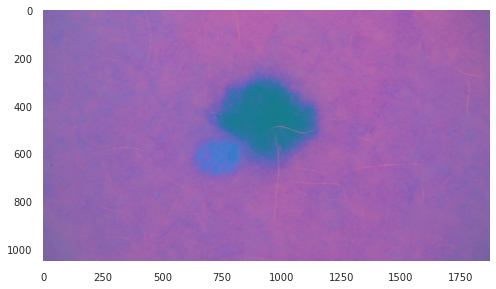

In [27]:
#visualize a sample image
plt.imshow(dcm.pixel_array)

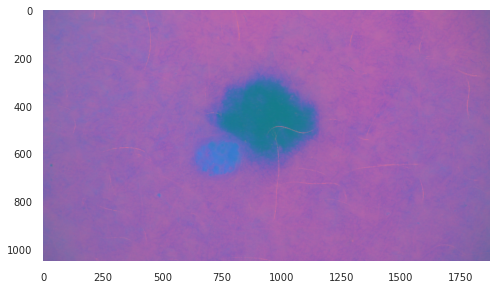

In [28]:
#Normalize image
plt.imshow(dcm.pixel_array/255)

In [29]:
#Now let's create a dataframe with header information from dicom images
## First, read all of my DICOM files into a list
import glob
mydicoms = glob.glob("/kaggle/input/siim-isic-melanoma-classification/train/*.dcm")
mydicoms[1:10]

['/kaggle/input/siim-isic-melanoma-classification/train/ISIC_2080947.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_1194836.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_2162118.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_1043313.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_1620401.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_1163139.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_3645670.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_5174173.dcm',
 '/kaggle/input/siim-isic-melanoma-classification/train/ISIC_4296030.dcm']

In [30]:
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, dcm.PatientAge, dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [31]:
#all_data

In [32]:
dicom_df = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [33]:
dicom_df.describe()

,Rows,Columns
count,33126.000000,33126.000000
mean,2678.758256,4039.630381
std,1437.617626,2109.145590
min,480.000000,640.000000
25%,1053.000000,1872.000000
50%,3456.000000,5184.000000
75%,4000.000000,6000.000000
max,6000.000000,6000.000000


In [34]:
dicom_df.sample(5)

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
18272,"""ISIC_6187353""",035Y,M,"""XC""",ISIC 2020 Grand Challenge image,1936,2592
20464,"""ISIC_8446988""",060Y,M,"""XC""",ISIC 2020 Grand Challenge image,480,640
27526,"""ISIC_3339465""",025Y,F,"""XC""",ISIC 2020 Grand Challenge image,4000,6000
14131,"""ISIC_8072117""",055Y,F,"""XC""",ISIC 2020 Grand Challenge image,4000,6000
5814,"""ISIC_4828093""",080Y,F,"""XC""",ISIC 2020 Grand Challenge image,480,640


In [35]:
train_df['image_path']="/kaggle/input/siim-isic-melanoma-classification/jpeg/train/" + train_df['image_name'] + ".jpg"

In [36]:
train_df['image_path'][1:10]

1    /kaggle/input/siim-isic-melanoma-classificatio...
2    /kaggle/input/siim-isic-melanoma-classificatio...
3    /kaggle/input/siim-isic-melanoma-classificatio...
4    /kaggle/input/siim-isic-melanoma-classificatio...
5    /kaggle/input/siim-isic-melanoma-classificatio...
6    /kaggle/input/siim-isic-melanoma-classificatio...
7    /kaggle/input/siim-isic-melanoma-classificatio...
8    /kaggle/input/siim-isic-melanoma-classificatio...
9    /kaggle/input/siim-isic-melanoma-classificatio...
Name: image_path, dtype: object

In [37]:
print(train_df['image_path'][0])

/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011.jpg


In [38]:
train_df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [39]:
#The distribution of target false:true is 55:1

> Note: The distribution of target false:true is 55:1

In [40]:
#import os
#print(os.listdir("/kaggle/input/siim-isic-melanoma-classification/jpeg/train"))

(4000, 6000, 3)
(1053, 1872, 3)
(1053, 1872, 3)
(4000, 6000, 3)
(4000, 6000, 3)
(3456, 5184, 3)
(1936, 2592, 3)
(4000, 6000, 3)
(4000, 6000, 3)
(2848, 4288, 3)
(4000, 6000, 3)
(1053, 1872, 3)
(4000, 6000, 3)
(4000, 6000, 3)
(4000, 6000, 3)
(2448, 3264, 3)
(4000, 6000, 3)
(4000, 6000, 3)
(3456, 5184, 3)
(2848, 4288, 3)


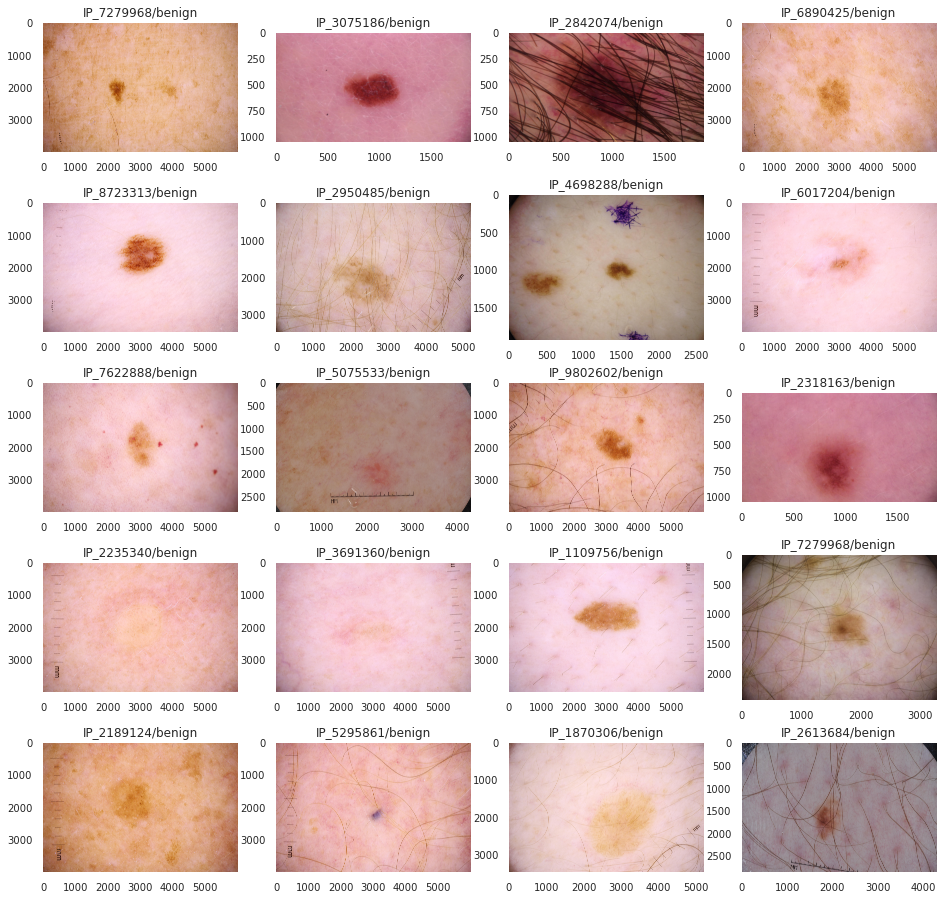

In [41]:
from skimage import io

#Let's evaulate how sample images look like

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_df['image_path'][1:32]
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    print(img.shape)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_df.iloc[ind]['patient_id'] + "/" + train_df.iloc[ind]['benign_malignant'])
    ind=ind+1
    

In [42]:
#Note the image sizes are all different

# Create split in the train data as train and val

In [43]:
from sklearn.model_selection import train_test_split
from random import sample

In [44]:
train_df['target_class']=train_df['target'].replace({1:'malignant', 0:'non_malignant'})

In [45]:
train_df['target_class'].sample(100)

25005    non_malignant
9197     non_malignant
32275    non_malignant
23170    non_malignant
7993     non_malignant
             ...      
1839     non_malignant
24536    non_malignant
15741    non_malignant
6264     non_malignant
25204    non_malignant
Name: target_class, Length: 100, dtype: object

In [46]:
def create_splits(dataframe):    
    
    # Todo - create more balanced sets as per real outcome percentage in validation data
    
    train_data, val_data = train_test_split(dataframe, 
                                   test_size = 0.2, 
                                   stratify = dataframe['target_class'])
    
    # create 50:50 split in the training data i.e. malignant and benign (50:50)
    
    malignant_index = train_data[train_data['target_class']=='malignant'].index.tolist()
    benign_index = train_data[train_data['target_class']=='non_malignant'].index.tolist()

    benign_sample = sample(benign_index, len(malignant_index))
    train_data = train_data.loc[malignant_index + benign_sample]
    
    # balance the validatation data as per the clinical proportion of actual outcome int he train dataset
    # current split is maligmant:benigh is 20:80
    
    malignant_index = val_data[val_data['target_class']=='malignant'].index.tolist()
    benign_index = val_data[val_data['target_class']=='non_malignant'].index.tolist()

    benign_sample = sample(benign_index, 4*len(malignant_index))
    val_data = val_data.loc[malignant_index + benign_sample]
    
    
    return train_data, val_data

In [47]:
train_data, val_data = create_splits(train_df)

In [48]:
len(train_data)

934

In [49]:
len(val_data)

585

# Image Augmentation

In [50]:
IMAGE_SIZE=(224,224)

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


In [52]:
test_df.sample(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
7610,ISIC_6903816,IP_2852390,male,45.0,lower extremity
1621,ISIC_1539449,IP_9497736,female,45.0,lower extremity
6778,ISIC_6144806,IP_2277592,female,35.0,torso


In [53]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

# Note the detailed augmentation is not done for validation data
val_idg = ImageDataGenerator(rescale=1. / 255.0)

train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         #directory='/kaggle/input/siim-isic-melanoma-classification/jpeg/train',
                                         x_col = 'image_path',
                                         y_col = 'target_class',
                                         class_mode = 'binary',
                                         target_size = IMAGE_SIZE, 
                                         batch_size = 64
                                         )

val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         #directory='/kaggle/input/siim-isic-melanoma-classification/jpeg/train',
                                         x_col = 'image_path',
                                         y_col = 'target_class',
                                         class_mode = 'binary',
                                         target_size = IMAGE_SIZE, 
                                         batch_size = 256
                                         )


Found 934 validated image filenames belonging to 2 classes.
Found 585 validated image filenames belonging to 2 classes.


In [54]:
valX, valY = val_gen.next()

In [55]:
test_df['image_path']="/kaggle/input/siim-isic-melanoma-classification/jpeg/test/" + test_df['image_name'] + ".jpg"

In [56]:
test_df.sample(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,image_path
3998,ISIC_3715917,IP_6357805,male,25.0,torso,/kaggle/input/siim-isic-melanoma-classificatio...
280,ISIC_0378391,IP_1939554,female,60.0,torso,/kaggle/input/siim-isic-melanoma-classificatio...
10146,ISIC_9215680,IP_7331155,male,55.0,torso,/kaggle/input/siim-isic-melanoma-classificatio...


In [57]:

#test_gen = val_idg.flow_from_dataframe(dataframe=test_df, directory=None)

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/kaggle/input/siim-isic-melanoma-classification/jpeg/test/",
    x_col="image_path",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(IMAGE_SIZE))

Found 10982 validated image filenames.


In [58]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [59]:
def load_pretrained_model(vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    vgg_model.summary()
    
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
   
    return vgg_model

In [60]:
def build_my_model(vargs):
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(load_pretrained_model(None))

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))

    return my_model

In [61]:
new_model=build_my_model(None)

553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [62]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [63]:

weight_path="{}_my_model.best.hdf5".format('melanoma_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=5)

callbacks_list = [checkpoint, early]

In [64]:
weight_path

'melanoma_class_my_model.best.hdf5'

In [65]:
new_model.save_weights(weight_path)

In [66]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [67]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train Model

history = new_model.fit_generator(train_gen,
                            validation_data = (valX, valY), 
                            epochs = 6, # 10
                           callbacks = callbacks_list)

In [72]:
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = val_gen.n // val_gen.batch_size

history = new_model.fit_generator(generator = train_gen,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_gen,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/14 [===>..........................] - ETA: 9:42 - loss: 0.8973 - binary_accuracy: 0.4688 

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/14 [=======>......................] - ETA: 7:34 - loss: 0.8088 - binary_accuracy: 0.5117 

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/14 [===========>..................] - ETA: 5:56 - loss: 0.7808 - binary_accuracy: 0.5286

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/14 [================>.............] - ETA: 4:26 - loss: 0.7914 - binary_accuracy: 0.5312

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/14 [==============================] - 538s 38s/step - loss: 0.7993 - binary_accuracy: 0.5057 - val_loss: 0.7559 - val_binary_accuracy: 0.3398
Epoch 2/10
14/14 [==============================] - 513s 37s/step - loss: 0.7648 - binary_accuracy: 0.5230 - val_loss: 0.5960 - val_binary_accuracy: 0.7568
Epoch 3/10
 5/14 [=========>....................] - ETA: 3:23 - loss: 0.7399 - binary_accuracy: 0.5204

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/14 [==============================] - 366s 26s/step - loss: 0.7173 - binary_accuracy: 0.5552 - val_loss: 0.6683 - val_binary_accuracy: 0.6140
Epoch 4/10
 2/14 [===>..........................] - ETA: 8:59 - loss: 0.6902 - binary_accuracy: 0.5547 

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/14 [=====>........................] - ETA: 9:46 - loss: 0.6711 - binary_accuracy: 0.5677

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/14 [==============>...............] - ETA: 5:46 - loss: 0.6864 - binary_accuracy: 0.5647

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/14 [==============================] - 548s 39s/step - loss: 0.6641 - binary_accuracy: 0.5874 - val_loss: 0.6652 - val_binary_accuracy: 0.5938
Epoch 5/10
14/14 [==============================] - 574s 41s/step - loss: 0.6505 - binary_accuracy: 0.6299 - val_loss: 0.6593 - val_binary_accuracy: 0.6444
Epoch 6/10
14/14 [==============================] - 297s 21s/step - loss: 0.6165 - binary_accuracy: 0.6752 - val_loss: 0.8379 - val_binary_accuracy: 0.5775
Epoch 7/10
 3/14 [=====>........................] - ETA: 7:08 - loss: 0.5945 - binary_accuracy: 0.7108

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/14 [=========>....................] - ETA: 6:30 - loss: 0.5811 - binary_accuracy: 0.7109

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/14 [==============================] - 534s 38s/step - loss: 0.5959 - binary_accuracy: 0.7002 - val_loss: 0.6850 - val_binary_accuracy: 0.5781
Epoch 8/10
14/14 [==============================] - 574s 41s/step - loss: 0.5959 - binary_accuracy: 0.6886 - val_loss: 0.7647 - val_binary_accuracy: 0.5775
Epoch 9/10
14/14 [==============================] - 303s 22s/step - loss: 0.5797 - binary_accuracy: 0.6896 - val_loss: 0.7020 - val_binary_accuracy: 0.6018
Epoch 10/10
14/14 [==============================] - 540s 39s/step - loss: 0.5610 - binary_accuracy: 0.7188 - val_loss: 0.6428 - val_binary_accuracy: 0.6309


# Predict from the model

In [73]:
new_model.load_weights(weight_path)

In [ ]:
#pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

#test_generator.reset()
#pred_Y = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
pred_Y = new_model.predict_generator(val_gen, steps=14, verbose=1)

In [ ]:
#pred_Y

In [ ]:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("seaborn")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [ ]:
#plot_history(history)

In [ ]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

In [ ]:
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

In [ ]:
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

In [ ]:
#plot_auc(valY, pred_Y)

In [ ]:
#plot_pr(valY, pred_Y)

In [74]:
#Inpect what is needed in sample submission
#submission_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
#submission_df.sample(3)
column_names=["image_name", "target"]
submission_df = pd.DataFrame(columns = column_names)
submission_df.head()

,image_name,target


In [75]:
test_generator.reset()
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST = test_generator.n / test_generator.batch_size
pred = new_model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

344/343 [==============================] - 4291s 12s/step


In [76]:
pred[:10]

array([[0.6234415 ],
       [0.5049666 ],
       [0.5109959 ],
       [0.5439345 ],
       [0.52732337],
       [0.5080521 ],
       [0.537855  ],
       [0.52496785],
       [0.5098915 ],
       [0.5307662 ]], dtype=float32)

In [77]:
pred = np.array(pred).ravel()

submission_df['target'] = pred.tolist()
submission_df['image_name'] = test_df['image_name']

In [78]:
submission_df.head()

,image_name,target
0,ISIC_0052060,0.623442
1,ISIC_0052349,0.504967
2,ISIC_0058510,0.510996
3,ISIC_0073313,0.543935
4,ISIC_0073502,0.527323


In [79]:
submission_df.to_csv('submission.csv',index=False)

In [80]:
import os
cwd = os.getcwd()
print("cwd: ", cwd)
print(os.listdir(cwd))
print(os.path.abspath(cwd))

cwd:  /kaggle/working
['__notebook_source__.ipynb', 'submission.csv', 'melanoma_class_my_model.best.hdf5']
/kaggle/working


Once you we are satisfied with the model, we'll use the test data and generate similar test_gen to predict on test data. I find this [article](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c) very useful to implement the final step to use model to predict on the test data. 

In [81]:
len(submission_df)

10982

In [82]:
test_df.tail(6)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,image_path
10976,ISIC_9992226,IP_0912606,male,45.0,lower extremity,/kaggle/input/siim-isic-melanoma-classificatio...
10977,ISIC_9992485,IP_4152479,male,40.0,torso,/kaggle/input/siim-isic-melanoma-classificatio...
10978,ISIC_9996992,IP_4890115,male,35.0,torso,/kaggle/input/siim-isic-melanoma-classificatio...
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity,/kaggle/input/siim-isic-melanoma-classificatio...
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity,/kaggle/input/siim-isic-melanoma-classificatio...
10981,ISIC_9999302,IP_6214039,male,30.0,upper extremity,/kaggle/input/siim-isic-melanoma-classificatio...
